## Import packages and Load Data

In [1]:
import csv
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

with open('../data/MaintIE/gold_release.json', 'r', encoding='utf-8') as file:
    gold_data = json.load(file)

with open('../data/MaintIE/silver_release.json', 'r', encoding='utf-8') as file:
    silver_data = json.load(file)

In [2]:
# Get undesirable events from MaintIE
def get_events(maintie_data):
    """ Get the events from MaintIE data. """
    events = {'UndesirableState': [], 'UndesirableProperty': [], 'UndesirableProcess': []}
    for d in maintie_data:
        for entity in d['entities']:
            start_idx = entity['start']
            end_idx = entity['end']
            event = " ".join(d['tokens'][start_idx:end_idx])
            text = d['text']
            if 'UndesirableState' in entity['type']:
                events['UndesirableState'].append([event, text])
            if 'UndesirableProperty' in entity['type']:
                events['UndesirableProperty'].append([event, text])
            if 'UndesirableProcess' in entity['type']:
                events['UndesirableProcess'].append([event, text])
    total_events = len(events['UndesirableState']) + len(events['UndesirableProperty']) + len(events['UndesirableProcess'])
    print("{:<20} {}".format("UndesirableState", len(events['UndesirableState'])))
    print("{:<20} {}".format("UndesirableProperty", len(events['UndesirableProperty'])))
    print("{:<20} {}".format("UndesirableProcess", len(events['UndesirableProcess'])))
    print("{:<20} {}".format("Total", total_events))
    return events

# Write the data to a CSV file
def write_csv(data, csv_file, header):
    """ Write the data to a CSV file. """
    with open(csv_file, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(data)

# Write the data to a txt file
def write_txt(data, txt_file):
    """ Write the data to a txt file. """
    with open(txt_file, 'w', encoding='utf-8') as file:
        for d in data:
            file.write(d + '\n')

In [3]:
# Print the count of entities and relations
def print_count(title, count_dict):
    """ Print the count dictionary in a table format. """
    print("{:<30} {}".format(f"{title}", "Count"))
    print("-" * 40)
    for key, value in count_dict.items():
        print("{:<30} {}".format(key, value))
    print("-" * 40)
    print("{:<30} {}".format("Total", sum(count_dict.values())))
    print()

# Analyse the datasets from MaintIE
def maintie_analysis(maintie_data):
    """ Analyse the gold/silver dataset from MaintIE. """
    entity_count, relation_count, unique_entity_count, unique_relation_count = {}, {}, {}, {}
    seen_entities, seen_relations = [], []

    for data in maintie_data:
        # count number of entities {type: count}
        for entity in data['entities']:
            entity_type = entity['type'].split('/')[0]
            if entity_type not in entity_count:
                entity_count[entity_type] = 1
            else:
                entity_count[entity_type] += 1
        
        # count number of relations {type: count}
        for relation in data['relations']:
            relation_type = relation['type']
            if relation_type not in relation_count:
                relation_count[relation_type] = 1
            else:
                relation_count[relation_type] += 1
                
        # count number of unique entities {type: count}
        for entity in data['entities']:
            entity_type = entity['type'].split('/')[0]
            entity_text = " ".join(data['tokens'][entity['start']:entity['end']]).lower().strip()
            unique_entity_key = (entity_text, entity_type)
            if unique_entity_key not in seen_entities:
                seen_entities.append(unique_entity_key)
                if entity_type not in unique_entity_count:
                    unique_entity_count[entity_type] = 1
                else:
                    unique_entity_count[entity_type] += 1
                    
        # count number of unique relations {type: count}
        for relation in data['relations']:
            relation_type = relation['type']
            head = relation['head']
            tail = relation['tail']
            head_entity = data['entities'][head]
            tail_entity = data['entities'][tail]
            head_entity_type = head_entity['type'].split('/')[0]
            tail_entity_type = tail_entity['type'].split('/')[0]
            head_entity_text = " ".join(data['tokens'][head_entity['start']:head_entity['end']]).lower().strip()
            tail_entity_text = " ".join(data['tokens'][tail_entity['start']:tail_entity['end']]).lower().strip()
            unique_head_key = (head_entity_text, head_entity_type)
            unique_tail_key = (tail_entity_text, tail_entity_type)
            unique_relation_key = (unique_head_key, unique_tail_key, relation_type)

            if unique_relation_key not in seen_relations:
                seen_relations.append(unique_relation_key)
                if relation_type not in unique_relation_count:
                    unique_relation_count[relation_type] = 1
                else:
                    unique_relation_count[relation_type] += 1
    
    print_count("Entities", entity_count)
    print_count("Relations", relation_count)
    print_count("Unique Entities", unique_entity_count)
    print_count("Unique Relations", unique_relation_count)

In [4]:
# Print number of tokens in the maintie data
def number_tokens_analysis(maintie_data, data_name):
    """ Analyse the number of tokens in the maintie data. """
    min_tokens = 1000 # Minimum number of tokens
    max_tokens = 0    # Maximum number of tokens
    sum_tokens = 0    # Sum of tokens

    for data in maintie_data:
        tokens = data['tokens']
        if len(tokens) > max_tokens:
            max_tokens = len(tokens)
        if len(tokens) < min_tokens:
            min_tokens = len(tokens)
        sum_tokens += len(tokens)

    # Average number of tokens
    avg_tokens = round(sum_tokens / len(maintie_data), 2)
    
    print(f"{data_name} Tokens Count")
    print("{:<20} {}".format("Minimum Tokens:", min_tokens))
    print("{:<20} {}".format("Maximum Tokens:", max_tokens))
    print("{:<20} {}".format("Average Tokens:", avg_tokens))

In [5]:
# Print all possible head-tail relations from the maintie data
def maintie_head_tail(data):
    """ Get the head and tail entities from the MaintIE data. """
    head_tail_relation = []
    for d in data:
        for r in d['relations']:
            head = r['head']
            tail = r['tail']
            head_entity = d['entities'][head]
            tail_entity = d['entities'][tail]
            head_type = head_entity['type'].split('/')[0]
            tail_type = tail_entity['type'].split('/')[0]
            
            # Undesirable State / Property / Process
            if "Undesirable" in head_entity['type']:
                head_subtype = head_entity['type'].split('/')[1]
                head_tail_relation.append((head_subtype, tail_type, r['type']))
                continue
            
            if "Undesirable" in tail_entity['type']:
                tail_subtype = tail_entity['type'].split('/')[1]
                head_tail_relation.append((head_type, tail_subtype, r['type']))
                continue
            
            head_tail_relation.append((head_type, tail_type, r['type']))
    head_tail_relation = sorted(set(head_tail_relation))
    for h, t, r in head_tail_relation:
        print(f"{h} - {r} -> {t}")
    print("Total:", len(head_tail_relation))

In [6]:
# Count max number of isA or hasPart or contains (hierarchical) relations in an entry
def hierarchical_relation(data):
    """ Count max number of hierarchical relations in the data. """
    max_isA, max_hasPart, max_contains = 0, 0, 0
    max_isA_entry, max_hasPart_entry, max_contains_entry = [], [], []
    for d in data:
        count_isA, count_hasPart, count_contains = 0, 0, 0
        for r in d['relations']:
            if r['type'] == 'isA':
                count_isA += 1
            if r['type'] == 'hasPart':
                count_hasPart += 1
            if r['type'] == 'contains':
                count_contains += 1
        if count_isA >= max_isA and count_isA > 1:
            max_isA = count_isA
            max_isA_entry.append((max_isA, d['text']))
        if count_hasPart >= max_hasPart and count_hasPart > 1:
            max_hasPart = count_hasPart
            max_hasPart_entry.append((max_hasPart, d['text']))
        if count_contains >= max_contains and count_contains > 1:
            max_contains = count_contains
            max_contains_entry.append((max_contains, d['text']))
    
    # Print max counts
    print(f"{"isA":<10}{max_isA:<3}")
    for e in max_isA_entry:
        print(e)
    print(f"{"hasPart":<10}{max_hasPart:<3}")
    for e in max_hasPart_entry:
        print(e)
    print(f"{"contains":<10}{max_contains:<3}")
    for e in max_contains_entry:
        print(e)

## Gold Dataset Analysis

In [7]:
# Number of entities and relations (and unique)
print("Entities and Relations:")
maintie_analysis(gold_data)

# All types of relations
print("Types of Relations:")
maintie_head_tail(gold_data)

# Number of tokens (min, max, avg)
print("\nTokens Analysis:")
number_tokens_analysis(gold_data, "MaintIE Gold")

# Number of hierarchical relations
print("\nMax Hierarchical Relations:")
hierarchical_relation(gold_data)


Entities and Relations:
Entities                       Count
----------------------------------------
PhysicalObject                 1994
State                          438
Activity                       784
Process                        146
Property                       35
----------------------------------------
Total                          3397

Relations                      Count
----------------------------------------
hasPart                        533
hasParticipant/hasPatient      1206
isA                            364
hasParticipant/hasAgent        166
contains                       38
hasProperty                    34
----------------------------------------
Total                          2341

Unique Entities                Count
----------------------------------------
PhysicalObject                 672
State                          100
Activity                       141
Process                        24
Property                       7
------------------------------

## Silver Dataset Analysis

In [8]:
# Number of entities and relations (and unique)
print("Entities and Relations:")
maintie_analysis(silver_data)

# All types of relations
print("Types of Relations:")
maintie_head_tail(silver_data)

# Number of tokens (min, max, avg)
print("\nTokens Analysis:")
number_tokens_analysis(silver_data, "MaintIE Silver")

# Number of hierarchical relations
print("\nMax Hierarchical Relations:")
hierarchical_relation(silver_data)

Entities and Relations:
Entities                       Count
----------------------------------------
Activity                       5045
State                          2747
PhysicalObject                 13472
Process                        728
Property                       130
----------------------------------------
Total                          22122

Relations                      Count
----------------------------------------
hasPatient                     7761
hasPart                        3837
isA                            2512
hasAgent                       789
contains                       178
hasProperty                    123
----------------------------------------
Total                          15200

Unique Entities                Count
----------------------------------------
Activity                       373
State                          396
PhysicalObject                 2372
Process                        118
Property                       32
-----------------

## Extract Undesirable Events from MaintIE Gold Dataset

In [9]:
events_list = get_events(gold_data)
header = ["Event", "Text", "Failure Mode"]
directory = '../data/FMC-MWO2KG'
write_csv(events_list['UndesirableState'], f'{directory}/undesirable_state.csv', header)
write_csv(events_list['UndesirableProperty'], f'{directory}/undesirable_property.csv', header)
write_csv(events_list['UndesirableProcess'], f'{directory}/undesirable_process.csv', header)

# Unique states, properties, and processes
unique_states = set([x[0] for x in events_list['UndesirableState']])
unique_properties = set([x[0] for x in events_list['UndesirableProperty']])
unique_processes = set([x[0] for x in events_list['UndesirableProcess']])
write_txt(unique_states, f'{directory}/unique_states.txt')
write_txt(unique_properties, f'{directory}/unique_properties.txt')
write_txt(unique_processes, f'{directory}/unique_processes.txt')

UndesirableState     438
UndesirableProperty  32
UndesirableProcess   146
Total                616


## Analyse MaintIE Gold Mapped

In [10]:
import csv
entry_mappings = {} # {entry: [failure modes]}
obs_mappings = {} # {failure mode: [observation]}
unmapped = [] # [(entry, observation)]
num_unmapped = 0
with open('../data/MaintIE/gold_undesirable_mapped.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        if row[2] == '':
            unmapped.append((row[0], row[1]))
            num_unmapped += 1
            continue
        # Entry to failure mode mappings
        if row[0] in entry_mappings:
            entry_mappings[row[0]].append(row[2])
        else:
            entry_mappings[row[0]] = [row[2]]
        # Failure mode to observation mappings
        if row[2] in obs_mappings:
            if row[1] not in obs_mappings[row[2]]:
                obs_mappings[row[2]].append(row[1])
        else:
            obs_mappings[row[2]] = [row[1]]
unmapped = sorted(unmapped, key=lambda x: x[1])

In [11]:
print("One entry with multiple failure modes:")
for key, value in entry_mappings.items():
    if len(value) > 1:
        if len(set(value)) > 1:
            print(key, value)

One entry with multiple failure modes:
<id> blade light blown needs replacing ['STD', 'BRD']
bulk fuel tank cracked and leaking ['STD', 'LEA']
<id> headboard welds broken / cracked ['BRD', 'STD']
air brake line blown - requires replacing ['STD', 'BRD']
will not start - batteries unserviceable ['BRD', 'FTS']
<id> <id> chord is leaking air from crack ['STD', 'LEA']


In [12]:
print("\nFailure modes count:")
failure_modes = {}
for key, value in entry_mappings.items():
    for v in value:
        if v in failure_modes:
            failure_modes[v] += 1
        else:
            failure_modes[v] = 1
failure_modes = dict(sorted(failure_modes.items(), key=lambda item: item[1], reverse=True))
for key, value in failure_modes.items():
    print(key, value)
print("Unmapped:", num_unmapped)


Failure modes count:
BRD 132
STD 126
LEA 123
SER 20
ELE 14
STP 6
PLU 5
FTS 5
OHE 4
NOI 3
UST 2
AIR 1
OTH 1
FTF 1
VIB 1
Unmapped: 172


In [13]:
for key, value in obs_mappings.items():
    print(key, value)
for entry, obs in unmapped:
    print(f"{obs:<25}{entry}")

BRD ['not working', 'unserviceable', 'disconnected', 'failed', 'broken', 'needs replacing', 'need change out', 'requires replacing', 'require replacing', 'needs aerial', 'needs to be replaced', 'fail']
OHE ['warm', 'overheat fault', 'fault', 'overheating']
PLU ['plugged', 'blocked']
FTS ["doesn't work", "won't start", "doesn't turn on", 'will not start']
STP ['stuck on', 'on', 'running constantly']
ELE ['not charging', 'electrical fault', 'fault', 'electrical faults', 'faults', 'tripped', 'trip', 'shorted', 'tripping out']
SER ['to be fixed', 'out of service', 'missing', 'needs resealing', 'needs fitting', 'loose', 'need to be fitted', 'need adjusting', 'out of adjustment', 'needs extending']
STD ['blown', 'bent', 'cracked', 'worn', 'worn out', 'damage', 'damaged', 'needs repair', 'corroded', 'snapped', 'crack', 'cracks', 'hole', 'creeping', 'falling off', 'cracking']
AIR ['not reading']
NOI ['sounds continuously', 'noisy']
UST ['intermittent fault', 'fault']
OTH ['tight']
LEA ['leak',

## MaintIE Sentence Tokens Count Distribution

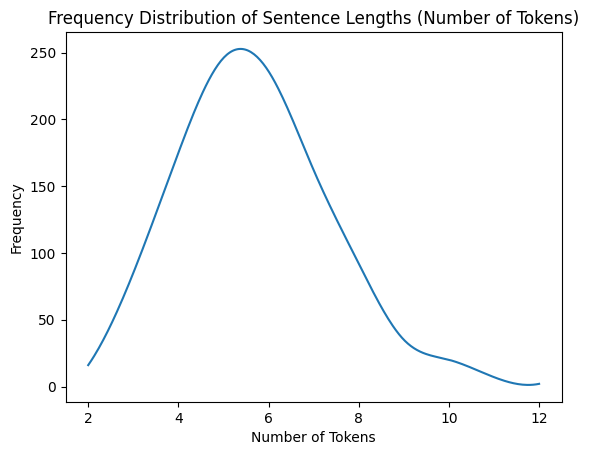

In [14]:
def token_distribution(maintie_data):
    tokens = [len(data['tokens']) for data in maintie_data]
    token_lengths, counts = np.unique(tokens, return_counts=True)
    x_new = np.linspace(token_lengths.min(), token_lengths.max(), 300)
    spline = make_interp_spline(token_lengths, counts, k=3)
    counts_smooth = spline(x_new)
    plt.plot(x_new, counts_smooth)
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.title('Frequency Distribution of Sentence Lengths (Number of Tokens)')
    plt.show()

token_distribution(gold_data)